# Monte Carlo Methods
                                                                                                        CI-B 2023
                                                                                                        Alexander, Lea, Filip        .

                                                                                                        

## Hello World: Monte Carlo Edition
### Estimating $\pi$


* $x,y \sim \mathcal{U_{[-1,1]}}.$
* Area of the square: $A_\square=4$
* Area of the circle: $A_O = \pi$
    * Is the sampled point inside of the the circle ($x^2 + y^2 < 1$)? 

Random Variable $X(\omega)$ = 1 .... point $x,y$ inside of circle, $X(\omega)$ = 0 otherwise

$P(X) = \frac{A_O}{A_\square} = \frac{\pi}{4}$



In [88]:
# imports for the notebook
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import seaborn as sns
plt.style.use("seaborn-v0_8-darkgrid")

%matplotlib widget


interactive(children=(IntSlider(value=1, description='n', max=10000, min=1), Output()), _dom_classes=('widget-…

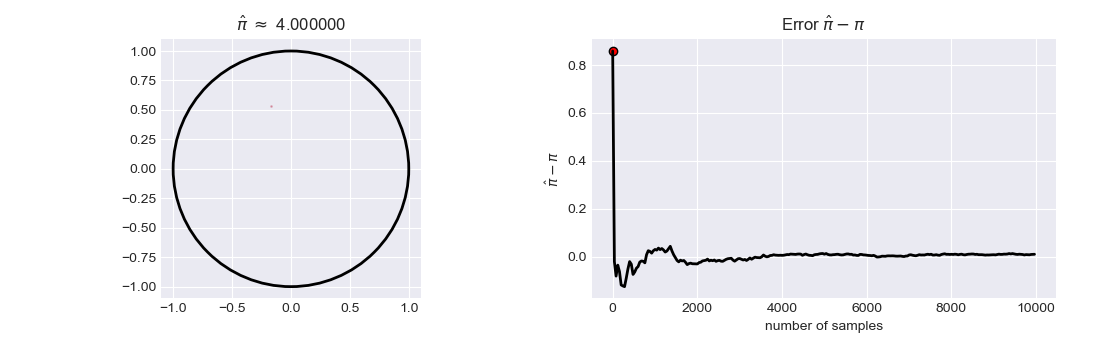

In [48]:
# Estimating Pi Example

def estimate_pi():
    num_samples = 10000
    np.random.seed(1)
    x = np.random.uniform(low=-1, high=1, size=num_samples)
    y = np.random.uniform(low=-1, high=1, size=num_samples)
    c = x**2 + y**2 < 1

    fig, axes = plt.subplots(1, 2, figsize=(11,3.5))
    ax = axes[0]; er = axes[1]; fig.tight_layout(pad=2.5)
    er.set_xlim(0, num_samples)


    circle = plt.Circle((0, 0), 1, fill=False, linewidth=2)
    pi_t = [4*((sum(c[:i])/i))-np.pi for i in range(1,num_samples, 40)]

    @widgets.interact(n=(1, num_samples, 1))
    def update(n = 1):
        ax.clear(); ax.set_aspect('equal');
        er.clear(); er.grid('on'); 
        ax.scatter(x[:n], y[:n], c=c[:n], alpha=0.25, s=1, cmap='coolwarm_r')
        pi_hat = 4*((sum(c[:n])/n))
        ax.add_patch(circle)

        er.plot(range(1,num_samples, 40), pi_t, c='black', linewidth=2)
        er.scatter(n, pi_hat-np.pi, c='red', edgecolors='k')


        ax.set_title(r"$\hat{\pi}$ $\approx$ " + f"{pi_hat:.6f}")
        er.set_title(r"Error $\hat{\pi}-\pi$")
        er.set_xlabel("number of samples"); er.set_ylabel(r"$\hat{\pi}-\pi$")
estimate_pi()


# What are Monte Carlo Methods trying to achieve?




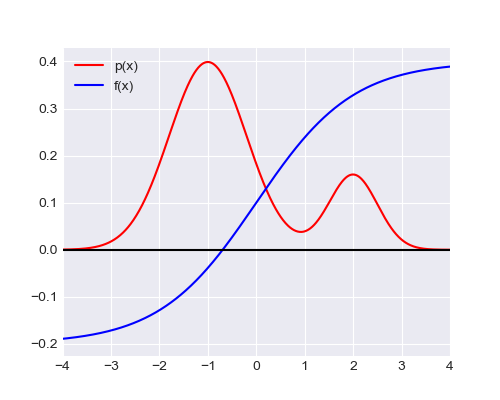

In [53]:
# What is the underlying problem that we are trying to solve with Monte Carlo?
def intro():
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    xs = np.linspace(-5, 5, 1000)

    gaussian1 = f(xs, -1, 0.8)* 0.8
    gaussian2 = f(xs, 2, 0.5)* 0.2
    sig = sigmoid(xs)*0.6 -0.2
    plt.figure(figsize=(5,4))

    px = gaussian1 + gaussian2
    plt.plot(xs, px, '-r', label="p(x)")
    plt.plot(xs, sig, '-b', label="f(x)")
    plt.plot(xs, np.zeros_like(xs), '-k')
    plt.legend()
    plt.xlim([-4, 4])
    plt.show()

intro()

We wish to estimate the expectation

$\mathop{\mathbb{E}}[f] = \int f(\bold{x})~p(\bold{x})~d\bold{x}$

The general idea behind sampling methods is to obtain a set of samples $\bold{x}^{i}$ from the $p(\bold{x})$

# Sample from a distribution

## Rejection Sampling 

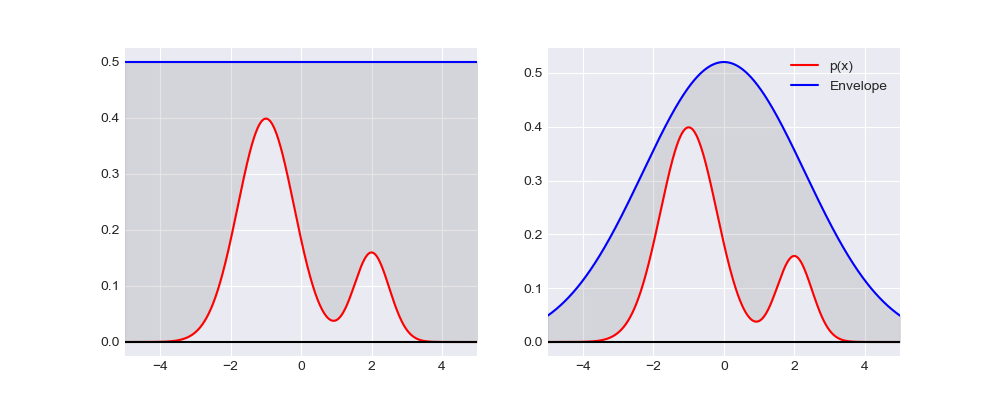

In [87]:
# What is the underlying problem that we are trying to solve with Monte Carlo?
def intro():
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    xs = np.linspace(-5, 5, 1000)

    gaussian1 = f(xs, -1, 0.8)* 0.8
    gaussian2 = f(xs, 2, 0.5)* 0.2
    gaus = f(xs,0,2.3)*3
    uniform = np.ones_like(xs)*0.5

    fig, axes = plt.subplots(1,2, figsize=(10,4))
    ax_u = axes[0]
    ax_n = axes[1]

    px = gaussian1 + gaussian2

    ax_n.fill_between(xs, gaus, px, alpha=0.2, color='gray')
    ax_n.plot(xs, px, '-r', label="p(x)")
    ax_n.plot(xs, gaus, '-b', label="Envelope")
    ax_n.plot(xs, np.zeros_like(xs), '-k')
    ax_n.legend()
    ax_n.set_xlim([-5, 5])


    ax_u.fill_between(xs, uniform, px, alpha=0.2, color='gray')
    ax_u.plot(xs, px, '-r', label="p(x)")
    ax_u.plot(xs, uniform, '-b', label="Envelope")
    ax_u.plot(xs, np.zeros_like(xs), '-k')
    # ax_u.legend()
    ax_u.set_xlim([-5, 5])

    plt.show()

intro()

pretty cool how we can actually draw from different distr.
basic idea: 
* take distr that we know how to draw from
* scale it over the Distr we want to sample from
* Reject samples that are above D(x)


interactive(children=(IntSlider(value=200, description='n_samples', max=100000, min=1, step=5), IntSlider(valu…

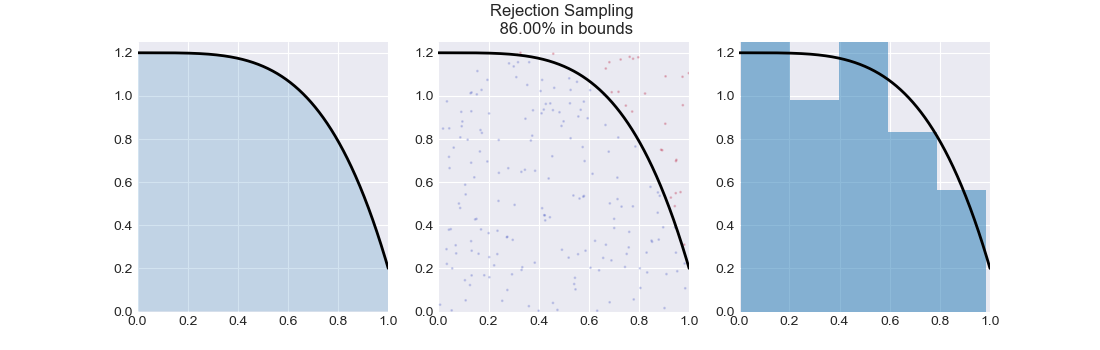

In [50]:
# Rejection sampling
# of y = 1.2 - x**4  [ -> integral_0^1 (1.2 - x**4 )dx = 1]
def rejection_sampling():
    def f(x):
        return 1.2 - x**4 # integral_0^1 (1.2 - x**4 )dx = 1

    xs = np.linspace(0, 1, 1000)
    ys = f(xs)
    fig, reject_ax = plt.subplots(1,3, figsize=(11, 3.5))

    reject_ax[0].plot(xs, ys, label="Forward Function", c='k', linewidth=2) 
    reject_ax[0].fill_between(xs, ys, 0, alpha=0.2)
    reject_ax[0].set_xlim([0, 1]), reject_ax[0].set_ylim([0, 1.25])
    n_max_samples = 100000
    x_all = np.random.uniform(low=0, high=1,    size=n_max_samples)
    y_all = np.random.uniform(low=0, high=1.2, size=n_max_samples)

    @widgets.interact(n_samples=(1, n_max_samples, 5), n_bins=(1,50,1))
    def update(n_samples = 200, n_bins=5):
        x = x_all[:n_samples]
        y = y_all[:n_samples]
        reject_ax[1].clear(); reject_ax[2].clear()

        c = y<f(x)

        reject_ax[1].plot(xs, ys, c='black', linewidth=2)
        reject_ax[1].scatter(x, y, alpha=0.2, label="Samples", c=c, cmap='coolwarm_r', s=1)
        reject_ax[1].set_xlim([0, 1]), reject_ax[1].set_ylim([0, 1.25]),
        reject_ax[1].set_title(f"Rejection Sampling \n {100*sum(c)/n_samples:.2f}% in bounds")

        reject_ax[2].plot(xs, ys, c='k', linewidth=2)
        reject_ax[2].hist(x[c], bins=n_bins, density=True, alpha=0.5)
        reject_ax[2].set_xlim([0, 1]), reject_ax[2].set_ylim([0, 1.25])

rejection_sampling()

## From Uniform to Normal

$\mathcal{U_{[0,1]}}  \rightarrow \mathcal{N}(\mu,\,\sigma^{2})$ ?


We will look at 3 ways:
* Rejection Sampling method
* Importance Sampling
* Box Müller transform (This is actually how you'd want to sample)

interactive(children=(IntSlider(value=500, description='n_samples', max=100000, min=1, step=5), IntSlider(valu…

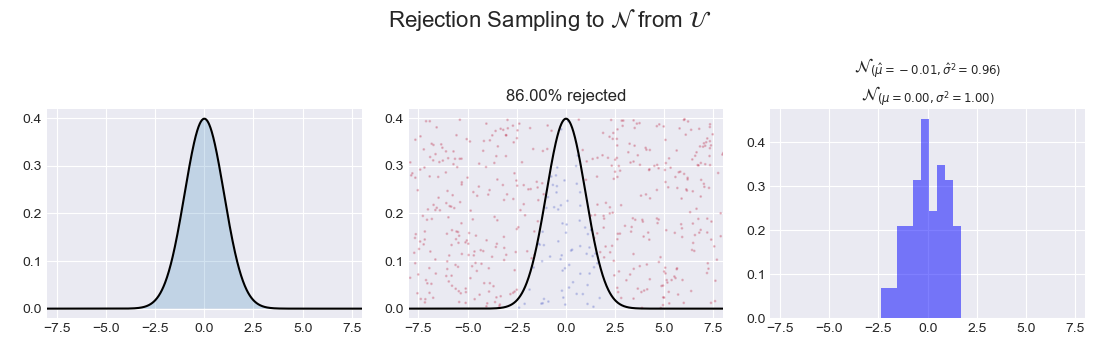

In [51]:
# Rejection sampling to a Gaussian
def rejection_sampling_gauss():
    def f(x, mean=0, sigma=0.1):
        return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

    fig, reject_gauss_ax = plt.subplots(1,3,  figsize=(11, 3.5))

    # reject_gauss_ax[0].set_xlim([0, 1]), reject_gauss_ax[0].set_ylim([0, 1.25])
    n_max_samples = 100000
    
    xbound = 8
    x_all = np.random.uniform(low=-xbound, high=xbound,size=n_max_samples)
    y_all = np.random.uniform(low=0, high=1, size=n_max_samples)
    fig.suptitle(r"Rejection Sampling to $\mathcal{N}$ from $\mathcal{U}$", fontsize=16)
    @widgets.interact(n_samples=(1, n_max_samples, 5), n_bins=(1,50,1), sigma2=(0.2, 5, 0.01), mean=(-5, 5, 0.01))
    def update(n_samples = 500, n_bins=10, sigma2=1, mean=0):
        xs = np.linspace(-xbound, xbound, 1000)
        sigma2=sigma2**(1/2)
        ys = f(xs, mean, sigma2)

        x = x_all[:n_samples]
        y = y_all[:n_samples]*ys.max() # y_all is 0-1, so scale it to the max of the gaussian (*1.1 to make it a bit bigger)
        reject_gauss_ax[0].clear(); reject_gauss_ax[1].clear(); reject_gauss_ax[2].clear()
        c = y<f(x, mean, sigma2)

        reject_gauss_ax[0].plot(xs, ys, label="Forward Function", c='k') 
        reject_gauss_ax[0].fill_between(xs, ys, 0, alpha=0.2)
        reject_gauss_ax[0].set_xlim([-xbound, xbound]), 

        reject_gauss_ax[1].plot(xs, ys, c='k')
        reject_gauss_ax[1].scatter(x, y, alpha=0.2, label="Samples", c=c, cmap='coolwarm_r', s=1)
        reject_gauss_ax[1].set_xlim([-xbound, xbound]),
        reject_gauss_ax[1].set_title(f"{100*(1-sum(c)/n_samples):.2f}% rejected")


        # reject_gauss_ax[2].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

        reject_gauss_ax[2].hist(x[c], bins=n_bins, density=True, alpha=0.5, label="Rejection Sampled", color='blue')
        reject_gauss_ax[2].set_xlim([-xbound, xbound]),
        mean_est = np.mean(x[c])
        sigma2_est = np.std(x[c])
        # reject_gauss_ax[2].set_title(r"$\mathcal{N}(\mu,\,\sigma^{2})$")
        reject_gauss_ax[2].set_title(r"$\mathcal{N}_{(\hat{\mu}=%.2f, \hat{\sigma}^2=%.2f)}$" "\n" r"$\mathcal{N}_{(\mu=%.2f, \sigma^2=%.2f)}$"%(mean_est, sigma2_est, mean, sigma2))
        fig.tight_layout()

rejection_sampling_gauss()





## A neat connection: Binomial distribution $\rightarrow \mathcal{N} $ 

Another method of estimating empirically a normal distribution is the binomial distribution

PMF := ${n| \choose k}  p^k  q{n-k}$ 

### The Galton Board
![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Galton_box.jpg/360px-Galton_box.jpg)

* each bounce goes to the left or right with equal probability (0.5)
* in the limit this approaches $\mathcal{N}$




## Importance Sampling

# Box-Müller Method for $\mathcal{U} \rightarrow \mathcal{N}$

/var/folders/b5/m4jbwtcs2fn0fl67yn85w1f00000gn/T/ipykernel_93914/3945173313.py:5: RuntimeWarning: invalid value encountered in log
  return np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
/var/folders/b5/m4jbwtcs2fn0fl67yn85w1f00000gn/T/ipykernel_93914/3945173313.py:8: RuntimeWarning: invalid value encountered in log
  return np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)


interactive(children=(IntSlider(value=1, description='n', max=10000, min=1), Output()), _dom_classes=('widget-…

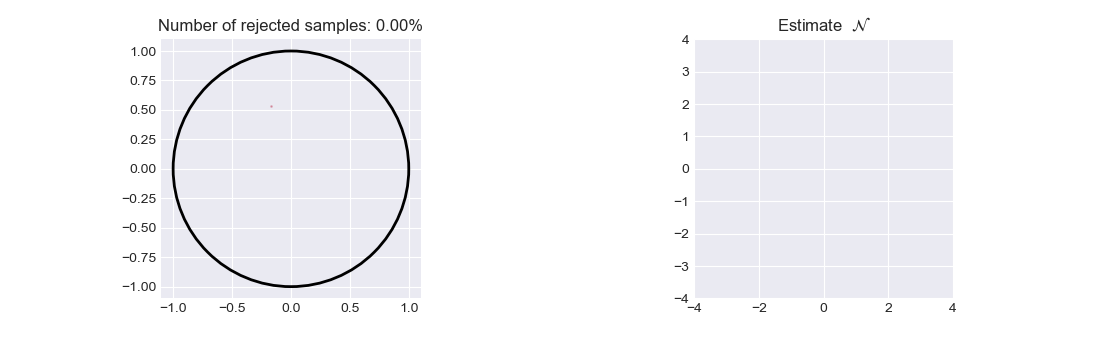

In [101]:
# Estimating Pi Example

def boxmuller():
    def z0(u1, u2):
        return np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
    
    def z1(u1, u2):
        return np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)
    
    num_samples = 10000
    np.random.seed(1)
    x = np.random.uniform(low=-1, high=1, size=num_samples)
    y = np.random.uniform(low=-1, high=1, size=num_samples)
    c = x**2 + y**2 < 1

    fig, axes = plt.subplots(1, 2, figsize=(11,3.5))
    ax = axes[0]; er = axes[1]; fig.tight_layout(pad=2.5)
    er.set_xlim(0, num_samples)

    circle = plt.Circle((0, 0), 1, fill=False, linewidth=2)
    z0 = z0(x, y)
    z1 = z1(x, y)
    @widgets.interact(n=(1, num_samples, 1))
    def update(n = 1):
        ax.clear(); ax.set_aspect('equal');
        er.clear(); er.set_aspect('equal');
        er.set_ylim(-4, 4);er.set_xlim(-4, 4)
        ax.scatter(x[:n], y[:n], c=c[:n], alpha=0.25, s=1, cmap='coolwarm_r')
        ax.add_patch(circle)


        er.scatter(z0[:n], z1[:n], c='blue', s=1, alpha=0.25)
        # sns.kdeplot(x=z0[:n], y=z1[:n], kind="kde", ax=er, alpha=0.7, color='black')

        ax.set_title(f"Number of rejected samples: {100*(n-sum(c[:n]))/n:.2f}%")
        er.set_title(r"Estimate  $\mathcal{N}$")

boxmuller()


## Expected Value

$$
\bar{X} = E(X) = \sum_{s \in S} p(s)X(s)\\
\text{"What are we going to get on average?"}\\
$$


## Variance


$$
Var[X] = E[(X - \bar{X})^2]\\
\text{"How tightly clustered will my results be?"}\\
$$





show S f(x) * p(x)/q(x) * q(x) <---- tractable since we can choose q(x)

## Inversion Sampling
